# import + global variable



In [ ]:
import requests  # HTTP requests 
from bs4 import BeautifulSoup  # pulling data out of HTML and XML files
import pickle  # binary protocols for serializing and de-serializing a Python object structure
import unicodedata  # access to the Unicode Character Database 
import re  # regular expression operations
from tqdm import tqdm 
import time

In [ ]:
root_url = "https://gameknot.com/"
annotated_url = "https://gameknot.com/list_annotated.pl?u=all"
page_url_templete = "https://gameknot.com/list_annotated.pl?u=all&p={page_numer}"

In [ ]:
moves_pattern = re.compile('(\w+\d[\+|#]?)[\n| ]')
# '+' == CHECK , '#' == CHECKMATE 
# https://regex101.com/r/nTnltx/1

In [ ]:
def get_soup(url):
  r = requests.get(url)
  while r.status_code != 200:
    print('----SLEEP----')
    time.sleep(30)
    r = requests.get(url)
  soup = BeautifulSoup(r.content, 'lxml') #'html.parser'
  return soup

# step 1 - get all games links


In [ ]:
# correct way for number_of_pages - add step 0, find number of pages from annotated_url. but thats will do :)

def get_pages(number_of_pages = 316):
  page_urls = [page_url_templete.format(page_numer=page_numer) for page_numer in range(number_of_pages)] # pages 0-315
  return page_urls

In [ ]:
def get_game_urls(page_urls, save=True):
  game_urls = []
  for page_url in tqdm(page_urls):
      soup = get_soup(page_url)
      for element in soup.find_all('tr', ["evn_list","odd_list"]): # ~40 games a page 
          links = element.find_all('a')
          game_link = links[1].get('href') # the second one is the relevant 
          game_urls.append(root_url + game_link)
  # save all links in pickle
  if save: 
    pickle.dump(game_urls, open("saved_game_urls.p","wb"))
  return game_urls

  # ~40 games per page

In [ ]:
# pretty way to save game_url with regex: 
# game_url_templete = "https://gameknot.com/annotation.pl/?gm={game_id}"
# id = re.search('\?gm=(\d+)', game_link)
# game_url = game_url_templete.format(game_id=id)

# step 2 - get games data



* game extra pages

In [ ]:
# each game link corresponding to the first page of a distinct game. 
# Some games finish in one page. But some others are multi-page.
def get_number_of_extra_pages(soup):
  try:
    page_elements = soup.find('table', ["paginator"]).find_all('td') # [Pages:, 1, ..., Next]
    return int(page_elements[-2].text)
  except:
    return 1

In [ ]:
# without the first page. if number_of_pages==1 returns []
def get_extra_pages(game_url, number_of_pages):
  return [game_url + "&pg=" + str(page_numer) for page_numer in range(1, number_of_pages)]

* one page data

<board, last move, commentary>

In [ ]:
def get_game_page_data(soup):
  results = soup.find("table",["dialog"]) # expecting only 1 table of this type

  if(results == None):
    print(soup.text)

  commentaries = get_commentaries_from_page(results)

  moves_and_boards = results.find_all("td", {"style":'vertical-align: top; width: 20%;'})
  moves_and_boards_text = [element.getText() for element in moves_and_boards]

  moves = get_moves_from_page(moves_and_boards_text)
  
  boards = get_boards_from_page(moves_and_boards_text)

  triplets = [trio for trio in zip(boards, moves, commentaries)] 

  return triplets

In [ ]:
def get_commentaries_from_page(results):
  commentaries = results.find_all("td", {"style":'vertical-align: top;'})
  commentaries_text = [commentary.getText() for commentary in commentaries]
  return commentaries_text

In [ ]:
def get_moves_from_page(moves):
  only_moves = [move[:move.find("<!--")] for move in moves]
  unicode_moves = [unicodedata.normalize('NFKD', move) for move in only_moves]
  moves_lists = [re.findall(moves_pattern, move) for move in unicode_moves]
  moves = [", ".join(moves_list) for moves_list in moves_lists] 
  return moves
  # move example - '\n1... d5 2. Bg2\n' --> 'd5, Bg3'

In [ ]:
def get_boards_from_page(boards):
  boards = [board[board.find("chess_diagram('")+15:] for board in boards]
  boards = [board[:board.find("'")] for board in boards]
  #boards = boards_to_texts(boards)
  return boards

board represention example: 'rnbqkbnr/ppp1pppp/8/3p4/8/6P1/PPPPPPBP/RNBQK1NR'

row 8 to 1, col a to h, lower case opponent(black), upper case(white), number for amount of empty cells

FEN :)


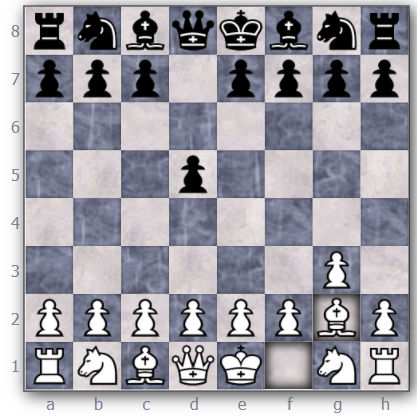

* all games data

In [ ]:
def get_games_data(game_urls, save=True):
  all_data = []
  counter=1
  for game in tqdm(game_urls, position=0, leave=True):
    game_data = []
    soup = get_soup(game)
    number_of_pages = get_number_of_extra_pages(soup)
    extra_pages = get_extra_pages(game, number_of_pages)
    game_pages = [game] + extra_pages
    for inx, page in enumerate(game_pages):
      if inx != 0:
        soup = get_soup(page)
      page_data = get_game_page_data(soup)
      game_data.extend(page_data)
    all_data.extend(game_data)
    if counter%100==0:
      pickle.dump(all_data, open(str(counter)+"data.p","wb"))
    counter+=1
  if save: 
    pickle.dump(all_data, open("saved_games_data.p","wb"))
  return all_data

# RUN ALL


get game_urls from pages:

In [ ]:
#pages = get_pages()

In [ ]:
#game_urls = get_game_urls(pages)

or load from saved pickle:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/NLP/Data/'

In [ ]:
game_urls = pickle.load(open(base_path+"saved_game_urls.p","rb"))

In [ ]:
len(game_urls)

12636

get_data

In [ ]:
data = get_games_data(game_urls[:1000])

100%|██████████| 1000/1000 [13:00<00:00,  1.28it/s]


In [ ]:
len(data)

29637

In [ ]:
data[5555]

('rnb1kb1r/3ppppp/5n2/qNpP4/8/8/PP2PPPP/R1BQKBNR w KQkq -|||last=d8a5',
 'Qa5+',
 'I think this is inaccurate. More usual is  Ba6 7. Nc3 transposing into main lines (1. d4 Nf6 2. c4 c5 3. d5 b5 4. cxb5 a6 5. bxa6 Bxa6 6. Nc3) reaches exactly the same position.')

In [ ]:
data_saved = pickle.load(open("saved_games_data.p","rb")) 

In [ ]:
len(data_saved)

29637